In [237]:
# Import libraries
import pandas as pd
import numpy as np
import os
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

data_directory = 'data/'

In [238]:
# Taking all the data and putting it in a dictionary
data_files = dict()
for file in os.listdir(data_directory):
    f = os.path.join(data_directory, file)
    data = pd.read_csv(f, sep=';')
    sales_data = pd.DataFrame(data)
    data_files[file] = sales_data

From all the data available, the files that matter the most are products, orders, and orders details. We will combine them together with relevant variables to us soon.

"Products" has all information about certain item the is or was been sold by the company.
"Orders" has details about a single order from a client.
"Orders details" has information about each item been sold on a certain order on "Orders".

Let's use the head function to get an idea of ​​what each of these files has.

In [239]:
# Analyse orders
data_files["products.csv"].head()

,product_id,product_name,supplier_id,category_id,quantity_per_unit,unit_price,units_in_stock,units_on_order,reorder_level,discontinued
0,1,Chai,8,1,10 boxes x 30 bags,18.00,39,0,10,1
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,1
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [240]:
data_files["order_details.csv"].head()

,order_id,product_id,unit_price,quantity,discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [241]:
data_files["orders.csv"].head()

,order_id,customer_id,employee_id,order_date,required_date,shipped_date,ship_via,freight,ship_name,ship_address,ship_city,ship_region,ship_postal_code,ship_country
0,10248,VINET,5,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,NaN,51100,France
1,10249,TOMSP,6,1996-07-05,1996-08-16,1996-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,NaN,44087,Germany
2,10250,HANAR,4,1996-07-08,1996-08-05,1996-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,RJ,05454-876,Brazil
3,10251,VICTE,3,1996-07-08,1996-08-05,1996-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,NaN,69004,France
4,10252,SUPRD,4,1996-07-09,1996-08-06,1996-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,NaN,B-6000,Belgium


In [242]:
# Data
data_files['orders.csv']['order_date'] = pd.to_datetime(data_files['orders.csv']['order_date'])
data_files['orders.csv']['year_month'] = data_files['orders.csv']['order_date'].dt.to_period('M')

# Merging relevant data
order_details_relevant = data_files["order_details.csv"][['order_id', 'product_id', 'unit_price', 'quantity', 'discount']]
orders_relevant = data_files["orders.csv"][['order_id', 'freight', 'customer_id', 'year_month', 'ship_country']]
products_relevant = data_files["products.csv"][['product_id', 'product_name']]

sales_data = pd.merge(order_details_relevant, orders_relevant, on='order_id', how='inner')
sales_data = pd.merge(sales_data, products_relevant, left_on='product_id', right_on='product_id', how='inner')

# Sort by each order from customers
sales_data = sales_data.sort_values('order_id')
sales_data = sales_data.reset_index(drop=True)

# Remove last month since data looks incomplete
sales_data = sales_data.loc[sales_data['year_month'] != '1998-05']

# Detect changes in order_id and add True to the new_order column
sales_data['new_order'] = sales_data['order_id'] != sales_data['order_id'].shift()
# Fill the first row with True since there's no previous row to compare to
sales_data.loc[0, 'new_order'] = True

# Convert the values to boolean
sales_data['new_order'] = sales_data['new_order'].astype(bool)

sales_data


,order_id,product_id,unit_price,quantity,discount,freight,customer_id,year_month,ship_country,product_name,new_order
0,10248,11,14.00,12,0.0,32.38,VINET,1996-07,France,Queso Cabrales,True
1,10248,72,34.80,5,0.0,32.38,VINET,1996-07,France,Mozzarella di Giovanni,False
2,10248,42,9.80,10,0.0,32.38,VINET,1996-07,France,Singaporean Hokkien Fried Mee,False
3,10249,14,18.60,9,0.0,11.61,TOMSP,1996-07,Germany,Tofu,True
4,10249,51,42.40,40,0.0,11.61,TOMSP,1996-07,Germany,Manjimup Dried Apples,False
...,...,...,...,...,...,...,...,...,...,...,...
2091,11062,53,32.80,10,0.2,29.93,REGGC,1998-04,Italy,Perth Pasties,True
2092,11062,70,15.00,12,0.2,29.93,REGGC,1998-04,Italy,Outback Lager,False
2093,11063,40,18.40,40,0.1,81.73,HUNGO,1998-04,Ireland,Boston Crab Meat,True
2094,11063,34,14.00,30,0.0,81.73,HUNGO,1998-04,Ireland,Sasquatch Ale,False


One of the performance indicators that we are going to use is the average ticket. It refers to the average spend or revenue generated by each transaction or sale over a given period of time

Average ticket: 1502.963143373494


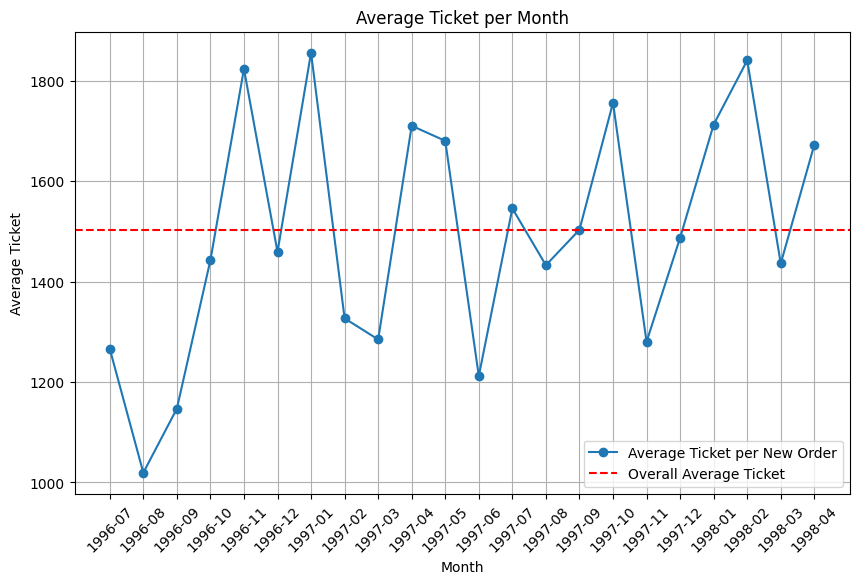

In [243]:
# Calculate medium ticket

sales_data['total_value'] = (sales_data['unit_price'] * (1-sales_data['discount'])) * sales_data['quantity']
average_ticket = sales_data['total_value'].sum() / len(data_files['orders.csv'])

print("Average ticket:", average_ticket)

# Group by year_month and calculate the total value for each month
monthly_ticket = sales_data.groupby('year_month')['total_value'].sum()

# Calculate the number of new orders for each month
new_orders_per_month = sales_data.groupby('year_month')['new_order'].sum()

# Calculate the average ticket per new order
average_ticket_per_new_order = monthly_ticket / new_orders_per_month

overall_average_ticket = sales_data['total_value'].sum() / len(data_files['orders.csv'])


plt.figure(figsize=(10, 6))
plt.plot(average_ticket_per_new_order.index.astype(str), average_ticket_per_new_order.values, marker='o', label='Average Ticket per New Order')
plt.axhline(y=overall_average_ticket, color='r', linestyle='--', label='Overall Average Ticket')
plt.xlabel('Month')
plt.ylabel('Average Ticket')
plt.title('Average Ticket per Month')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()


We will also use the churn rate. This one is an indicates the number of customers that stopped doing business with the company.

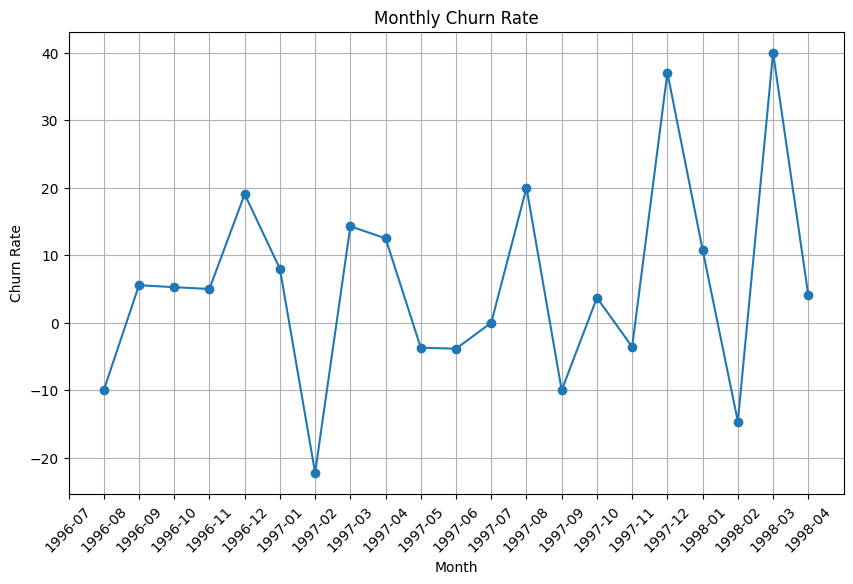

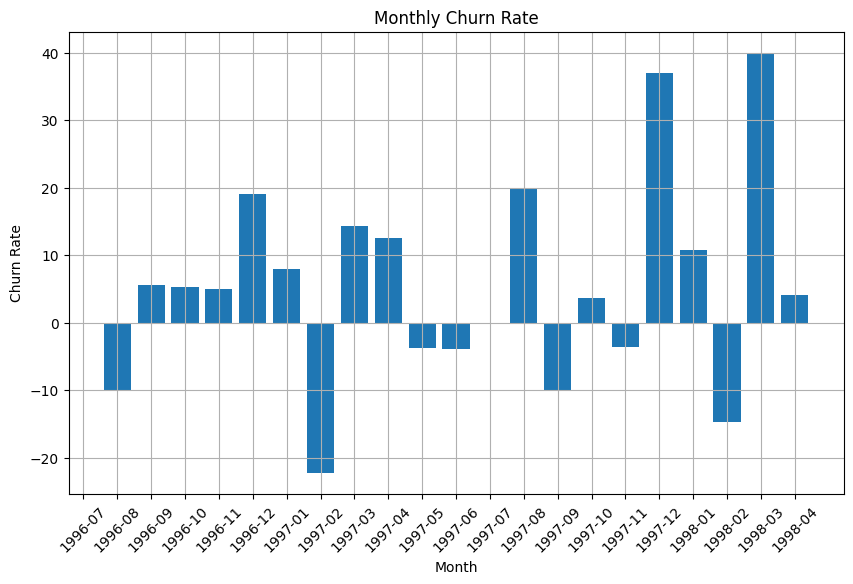

In [244]:
# Calculate Churn
unique_customers_per_month = sales_data.groupby('year_month')['customer_id'].nunique()

# Customers who purchased in the previous month but did not purchase in the current month
churned_customers_per_month = unique_customers_per_month.diff().fillna(0)

# Calculate the churn rate in percentage by dividing the number of customers who stopped buying by the total number of customers in the previous month.
churn_rate_per_month = churned_customers_per_month * 100/ unique_customers_per_month.shift()

# Plot the monthly churn rate
plt.figure(figsize=(10, 6))
plt.plot(churn_rate_per_month.index.astype(str), churn_rate_per_month.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Churn Rate')
plt.title('Monthly Churn Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(churn_rate_per_month.index.astype(str), churn_rate_per_month.values)
plt.xlabel('Month')
plt.ylabel('Churn Rate')
plt.title('Monthly Churn Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


One of the ways to increase the average ticket is to identify products that are frequently purchased together and suggest these products to customers as bundles. This can increase the total shopping cart value.

In our case, we plot items with at least 5 occurrences together in carts.

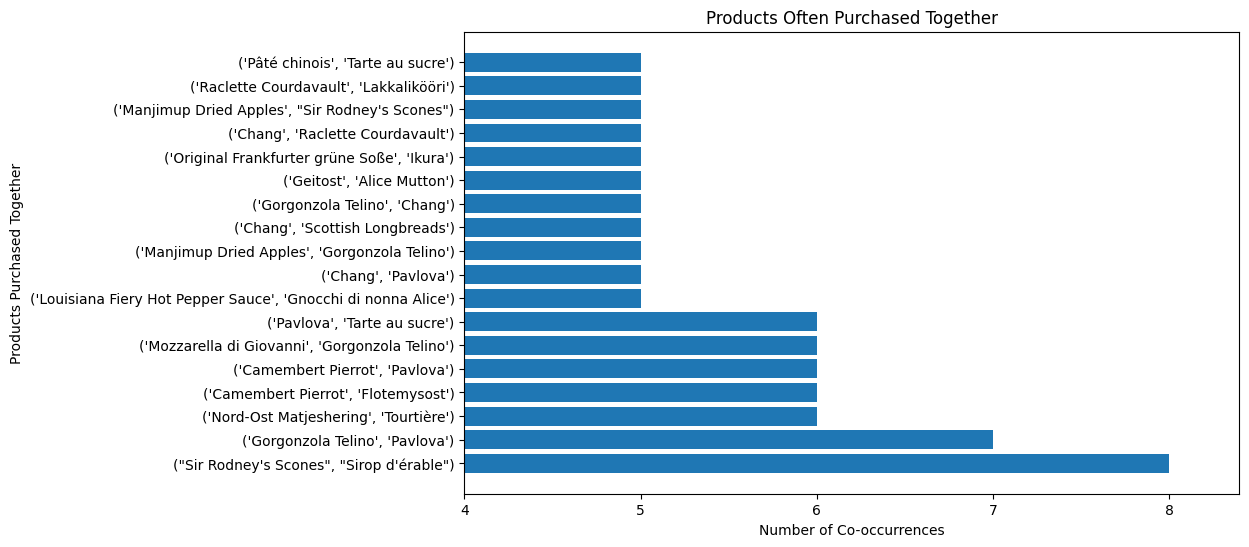

In [245]:
# Create a dictionary to store products purchased together
products_together = {}

# Group products by order
order_details = data_files['order_details.csv'][["order_id","product_id"]]

products_relevant = data_files["products.csv"][['product_id', 'product_name']]

items_sould = pd.merge(order_details, products_relevant, on='product_id', how='inner')

items_sould_grouped = items_sould.groupby("order_id")["product_name"].apply(list)

# Identify products frequently purchased together
for products in items_sould_grouped:
    pairs = list(combinations(products, 2))
    for pair in pairs:
        if pair in products_together:
            products_together[pair] += 1
        else:
            products_together[pair] = 1

products_together_df = pd.DataFrame(list(products_together.items()), columns=["products", "count"])

products_together_df = products_together_df.sort_values(by="count", ascending=False)
products_together_df = products_together_df.reset_index(drop=True)

# Show frequently bought products together
frequently_bought = products_together_df[products_together_df['count'] > 4]
""" print(frequently_bought) """

plt.figure(figsize=(10, 6))
plt.barh(frequently_bought["products"].apply(str), frequently_bought["count"])
plt.xlim(left=min(frequently_bought["count"]) - 1)
plt.xticks(range(min(frequently_bought["count"]) - 1, max(frequently_bought["count"]) + 1, 1))

plt.xlabel("Number of Co-occurrences")
plt.ylabel("Products Purchased Together")
plt.title("Products Often Purchased Together")
plt.show()

Average Order Processing Time:
Average difference between the "order_date" and "shipped_date" dates to measure how long, on average, it takes the business to process and ship orders.

It is visible that we have inconsistencies over the months with the time it takes the company to ship a certain item. Improvements in this regard could be beneficial.


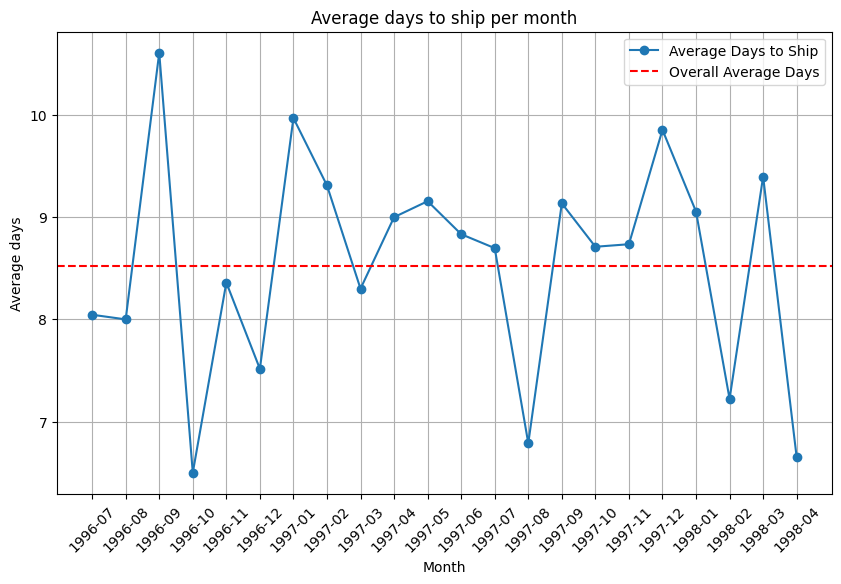

In [246]:

# Remove last month
data_files["orders.csv"] = data_files["orders.csv"].loc[data_files["orders.csv"]['year_month'] != '1998-05']

# Calculate day to ship per order and add on a column
data_files["orders.csv"]["days_to_ship"] = (pd.to_datetime(data_files["orders.csv"]["shipped_date"]) - pd.to_datetime(data_files["orders.csv"]["order_date"])).dt.days

# Group days to ship mean per month
monthly_days_to_ship = data_files["orders.csv"].groupby('year_month')['days_to_ship'].mean()

# Overall average days to ship
avg_days_to_ship = data_files["orders.csv"]["days_to_ship"].mean()


plt.figure(figsize=(10, 6))
plt.plot(monthly_days_to_ship.index.astype(str), monthly_days_to_ship.values, marker='o', label='Average Days to Ship')
plt.axhline(y=avg_days_to_ship, color='r', linestyle='--', label='Overall Average Days')
plt.xlabel('Month')
plt.ylabel('Average days')
plt.title('Average days to ship per month')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [247]:
data_files["products.csv"]["units_in_stock"] = pd.to_numeric(data_files["products.csv"]["units_in_stock"], errors="coerce")
data_files["products.csv"]["units_on_order"] = pd.to_numeric(data_files["products.csv"]["units_on_order"], errors="coerce")
# Calcular a média dos níveis de estoque considerando valores não nulos
data_files["products.csv"]["average_stock_level"] = data_files["products.csv"][["units_in_stock", "units_on_order"]].mean(axis=1, skipna=True)

# Remover linhas com valores ausentes antes de calcular a média
data_files["products.csv"] = data_files["products.csv"].dropna(subset=["average_stock_level"])

# Calcular a média dos níveis médios de estoque
avg_stock_level = data_files["products.csv"]["average_stock_level"].mean()

print("Average of average inventory levels:", avg_stock_level)

Average of average inventory levels: 25.318181818181817


We can observe through the monthly revenue graph that Northwind is in a phase of monthly income growth, however, some of its features can be improved for better performance.

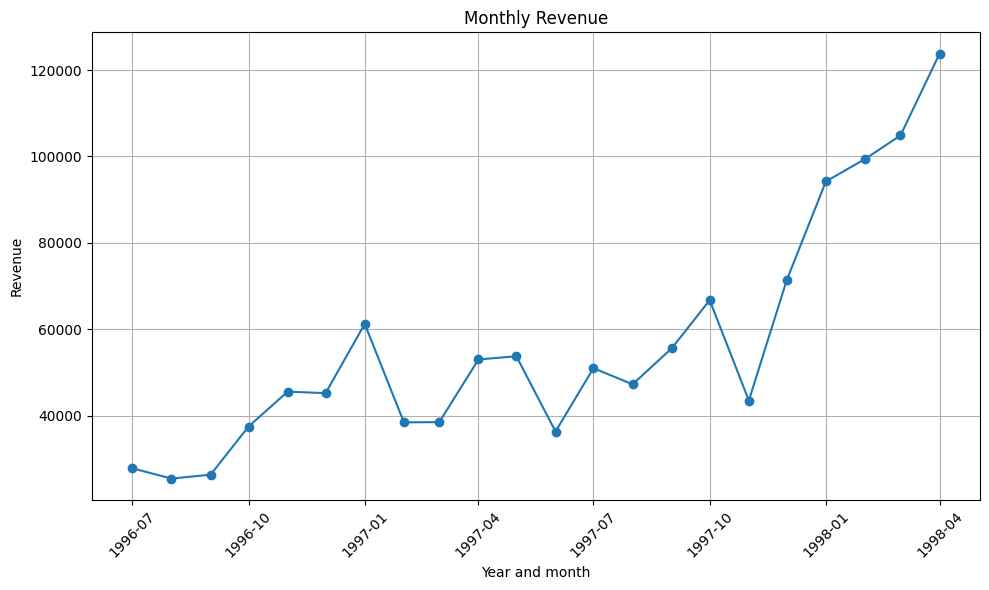

In [248]:
# Monthly billing over time
monthly_revenue = sales_data.groupby('year_month')['total_value'].sum()

monthly_revenue.index = pd.to_datetime(monthly_revenue.index.to_timestamp())

# Plot income over time
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker='o')
plt.title('Monthly Revenue')
plt.xlabel('Year and month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

Analyzing which are the countries that most demand the company's products is a good idea, so that we can focus advertising in these regions. Let's plot bar graphs that show the countries with the best order rates in the period studied.

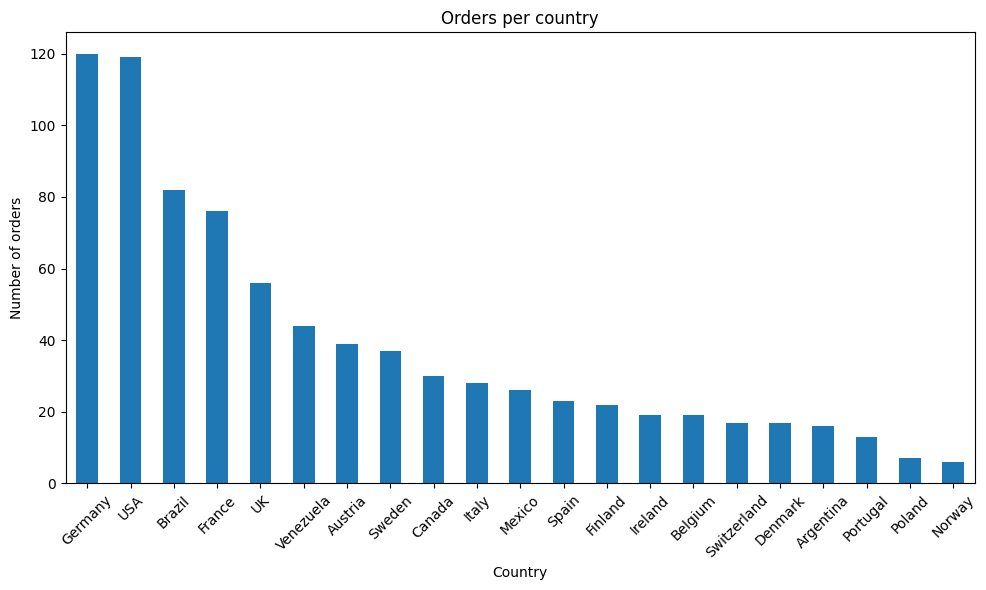

In [249]:
# Amount of orders per country
country_counts = data_files["orders.csv"]["ship_country"].value_counts()

# Bar graph
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar')
plt.title('Orders per country')
plt.xlabel('Country')
plt.ylabel('Number of orders')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

However, we have some changes on the next bar chart, since we evaluate the amount of money spent by them. We still have Germany and the United States at the top, however Austria won third place, despite being sixth in order quantity. Encouraging more orders made by customers from this country can generate more profits due to the good level of funds presented by them.

Also, USA, Germany, Brazil, France and UK should be central focus on 
advertising.

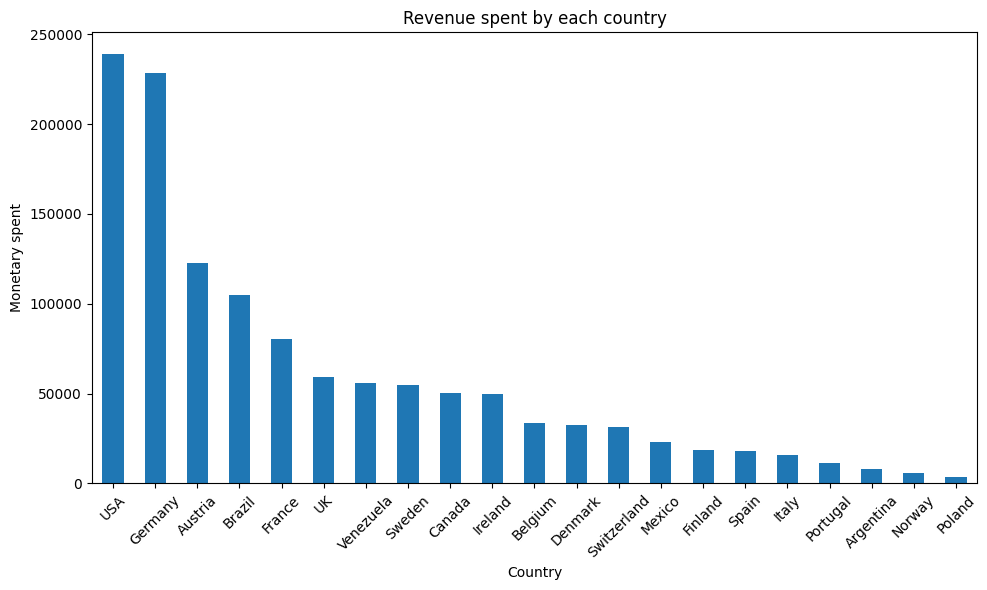

In [250]:
# Money spent on purchases by each country

country_revenue = sales_data.groupby('ship_country')['total_value'].sum()
country_revenue = country_revenue.sort_values(ascending=False)

# Bar graph
plt.figure(figsize=(10, 6))
country_revenue.plot(kind='bar')
plt.title('Revenue spent by each country')
plt.xlabel('Country')
plt.ylabel('Monetary spent')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

A strategy to increase the average ticket per customer consists of identifying the products that sell the most and thinking about how to present them together with less sold products.

That is, with this, less successful products can “piggyback” with the more profitable ones, generating a predictable income that guarantees the company's operations.

Let's plot the best and worst products.


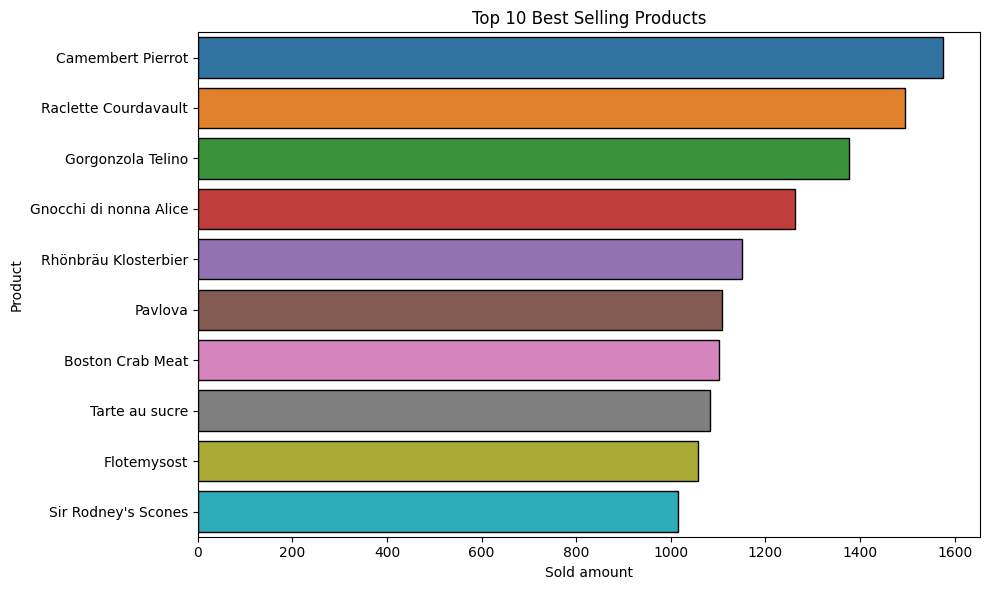

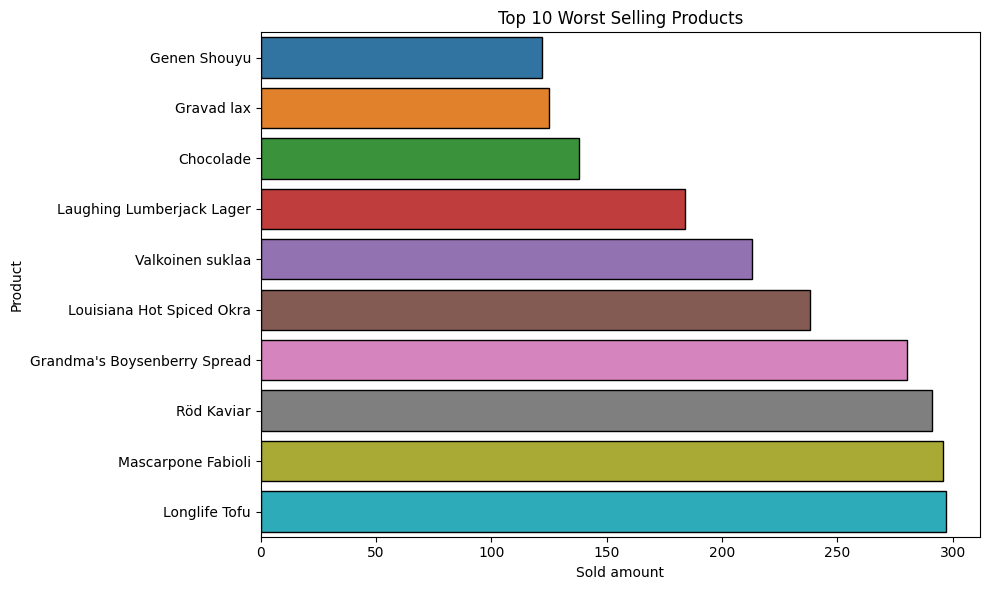

In [251]:
# Filter discontinued products
active_products = data_files['products.csv'][data_files['products.csv']['discontinued'] == False]
sales_data_active = sales_data[sales_data['product_name'].isin(active_products['product_name'])]

# Top 10 best selling products
top_products = sales_data_active.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(10)
# Top 10 worst selling products
lowest_products = sales_data_active.groupby('product_name')['quantity'].sum().sort_values(ascending=True).head(10)

# Best selling products bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, edgecolor='black')
plt.title('Top 10 Best Selling Products')
plt.xlabel('Sold amount')
plt.ylabel('Product')
plt.tight_layout()

# Worst selling products bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=lowest_products.values, y=lowest_products.index, edgecolor='black')
plt.title('Top 10 Worst Selling Products')
plt.xlabel('Sold amount')
plt.ylabel('Product')
plt.tight_layout()

plt.show()

However, it may be better to know market performances at a more recent point in time. So let's plot the best products from last month so we can analyse.

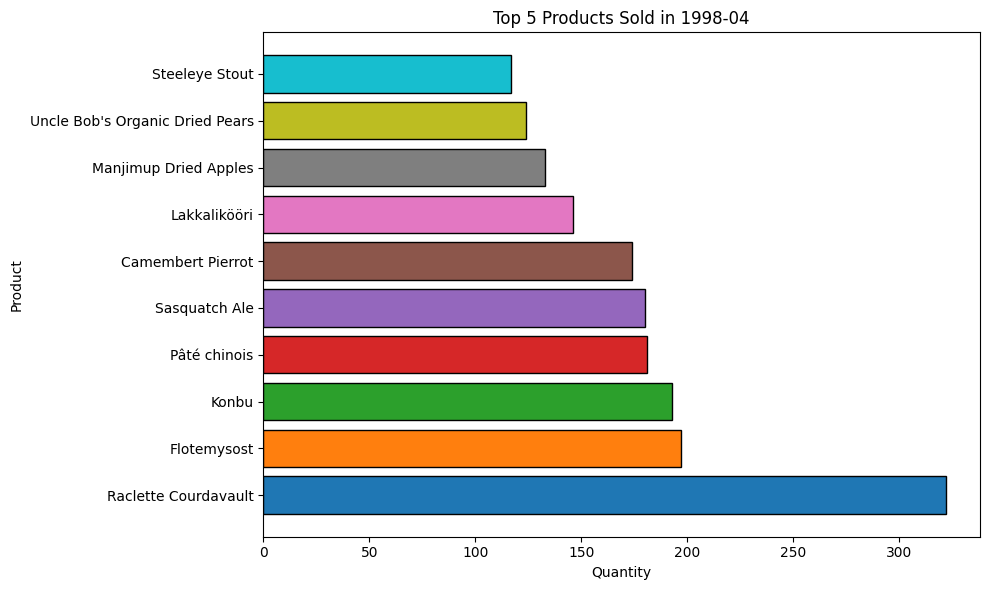

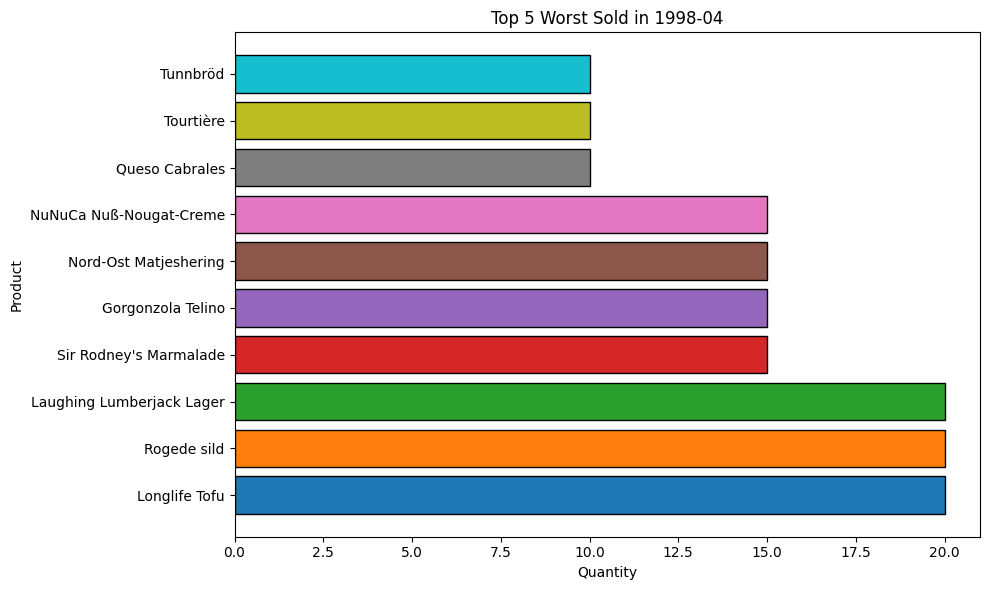

In [252]:
last_month = sales_data_active['year_month'].max()
monthly_product_sales = sales_data_active[sales_data_active['year_month'] == last_month]

product_sales = monthly_product_sales.groupby('product_name')['quantity'].sum().reset_index()

# Sort by quantity in descending order
product_sales = product_sales.sort_values('quantity', ascending=False)
top_products = product_sales.head(10)
worst_products = product_sales.tail(10)
plt.figure(figsize=(10, 6))
for _, data in top_products.iterrows():
    plt.barh(data['product_name'], data['quantity'], edgecolor='black')

plt.xlabel('Quantity')
plt.ylabel('Product')
plt.title(f'Top 5 Products Sold in {last_month}')
plt.tight_layout()
plt.show()
# Plot top 5 worst selling products
plt.figure(figsize=(10, 6))
for _, data in worst_products.iterrows():
    plt.barh(data['product_name'], data['quantity'], edgecolor='black')

plt.xlabel('Quantity')
plt.ylabel('Product')
plt.title(f'Top 5 Worst Sold in {last_month}')
plt.tight_layout()
plt.show()



Analysing how the discount can impact the amount of sold items is also relevant. We will plot the histogram to see if increasing the value of discounts is directly proportional to the increase in purchases of the item. 


The first graph is a histogram of the number of times items were purchased at a certain discount regardless of their quantity in the cart.

The secound one considers the amount of items bought.

The last one is a chart that shows the times a given quantity was purchased at a discount. This is to study whether higher discount percentages can make the customer buy more items in a single purchase.

As we can see, increasing the discount doesn't necessarily mean that we will have higher purchases. 5% seems to have performed very well considering he appeared in 179 of the carts.

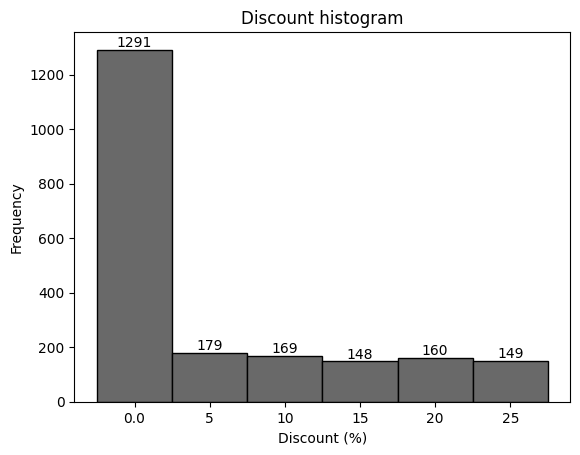

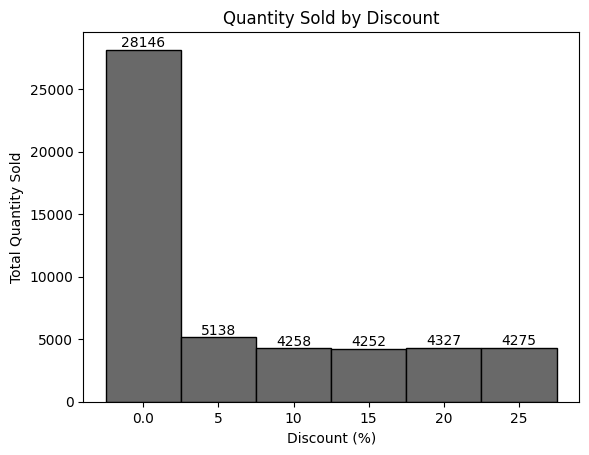

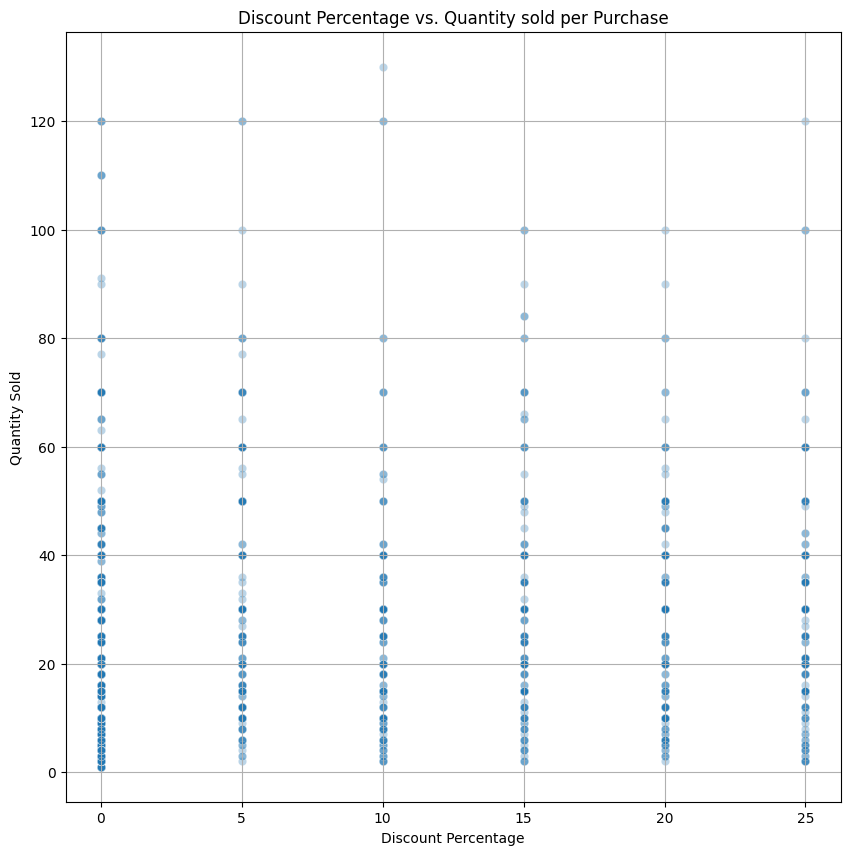

In [253]:
# Data
discount_percentage = sales_data['discount'] * 100
quantity_sold = sales_data['quantity']
bins = [0.0, 5, 10, 15, 20, 25, 30]  

bar_positions = [bin_start + (bin_end - bin_start) / 2 for bin_start, bin_end in zip(bins[:-1], bins[1:])]

# Histogram
hist, edges, _ = plt.hist(discount_percentage, bins=bins, color='dimgrey', edgecolor='black', align='mid')  # Definir o alinhamento das barras

plt.xlabel('Discount (%)')
plt.ylabel('Frequency')
plt.title('Discount histogram')

# Adjust
plt.xticks(bar_positions, bins[:-1])  

# Add values ​​to bars
for i in range(len(bins) - 1):
    plt.text(edges[i] + (edges[i + 1] - edges[i]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom')


plt.show()

# Calculate total quantities sold for each discount interval
quantity_by_discount = []
for bin_start, bin_end in zip(bins[:-1], bins[1:]):
    mask = (discount_percentage >= bin_start) & (discount_percentage < bin_end)
    total_quantity = np.sum(quantity_sold[mask])
    quantity_by_discount.append(total_quantity)

# Create the bar chart
plt.bar(bar_positions, quantity_by_discount, width=np.diff(bins), align='center', color='dimgrey', edgecolor='black')

# Add labels and title
plt.xlabel('Discount (%)')
plt.ylabel('Total Quantity Sold')
plt.title('Quantity Sold by Discount')

# Adjust x-axis labels
plt.xticks(bar_positions, bins[:-1])
# Add values to the bars
for bar_x, bar_height in zip(bar_positions, quantity_by_discount):
    plt.text(bar_x, bar_height, str(int(bar_height)), ha='center', va='bottom')


# Create a scatter plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x=discount_percentage, y=quantity_sold, alpha=0.3)
plt.xlabel('Discount Percentage')
plt.ylabel('Quantity Sold')
plt.title('Discount Percentage vs. Quantity sold per Purchase')
plt.grid(True)

plt.show()